In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import dabest
import mne

# Reading ERSP Data between Video and Picture-based Scenes

In [3]:
VIDEO_ALPHA=pd.read_csv('ERSP_VIDEO_ALPHA.csv')
VIDEO_BETA=pd.read_csv('ERSP_VIDEO_BETA.csv')
VIDEO_THETA=pd.read_csv('ERSP_VIDEO_THETA.csv')
TEXT_ALPHA=pd.read_csv('ERSP_TEXT_ALPHA.csv')
TEXT_BETA=pd.read_csv('ERSP_TEXT_BETA.csv')
TEXT_THETA=pd.read_csv('ERSP_TEXT_THETA.csv')

channels=pd.read_excel('EEG_SENSOR_NAMES.xlsx')
ch=channels.channels.values.tolist()

# Importing Tools for Topograms Analysis

In [5]:
import mne
channel_names = ['P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4', 'Cz', 'Fp1',
 'Fp2', 'T7', 'P7', 'O1', 'O2', 'F7', 'F8', 'P8', 'T8']
channel_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']
sfreq = 250  # in Hertz
info = mne.create_info(channel_names, sfreq, channel_types)
#montage =  mne.channels.make_standard_montage("easycap-M1")
montage =  mne.channels.make_standard_montage("standard_1020")
info.set_montage(montage);
am, bm =mne.channels.find_ch_adjacency(info,ch_type='eeg')

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 18


# Comparing ERSP Data in Theta-band

### Permutation statistics and differences

In [6]:
da=TEXT_THETA[ch].to_numpy()
db=VIDEO_BETA[ch].to_numpy()
X=[da,db]
F_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(X,n_permutations=10000,tail=0,adjacency=am);
print(clusters)
print(cluster_p_values)
print(F_obs)

mask_theta = np.empty([len(ch)])
mask_theta.fill(False)
for i in clusters:
    mask_theta[i] = True 

Using a threshold of 3.963472
stat_fun(H1): min=0.001405 max=25.873099
Running initial clustering …
Found 1 cluster


/var/folders/qc/srdfyg99647d_vkjg4_13mp80000gn/T/ipykernel_29637/2877864806.py:4: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(X,n_permutations=10000,tail=0,adjacency=am);


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

[(array([ 0,  6, 11, 12, 13, 16]),)]
[0.0031]
[8.60251367e+00 1.97538879e+00 8.85488087e-01 1.40509956e-03
 1.54313903e-01 3.60200235e+00 1.24521178e+01 3.32143097e+00
 1.05797902e+00 6.53769762e-01 8.89816017e-02 5.91625842e+00
 2.58730993e+01 2.40536567e+01 2.12408251e-01 4.98602544e-01
 1.90697758e+01 1.70810914e-02]


### Visualization (box-plot)

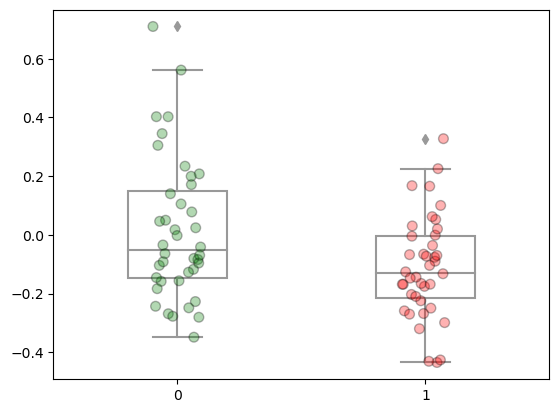

In [11]:
import seaborn as sns

VIDEO_THETA['Video']=(VIDEO_THETA['O1']+VIDEO_THETA['O2']+VIDEO_THETA['P3']+VIDEO_THETA['P4']+VIDEO_THETA['T5']+VIDEO_THETA['T6'])/6
TEXT_THETA['Picture']=(TEXT_THETA['O1']+TEXT_THETA['O2']+TEXT_THETA['P3']+TEXT_THETA['P4']+TEXT_THETA['T5']+TEXT_THETA['T6'])/6
result_THETA=()
result_THETA=pd.concat([VIDEO_THETA, TEXT_THETA], axis = 1)
result_THETA = result_THETA.loc[:,~result_THETA.columns.duplicated()].copy()
result_THETA=result_THETA[['participant','Video','Picture']]


g1=sns.boxplot([TEXT_THETA['Picture'],VIDEO_THETA['Video']],width=0.4, color='white')
g1=sns.stripplot([TEXT_THETA['Picture'],VIDEO_THETA['Video']],linewidth=1, edgecolor='black', alpha=0.3,palette=["green", "red"],size=7)

### Visualization (topoplot)

Text(0.5, 1.0, 'ERSP difference')

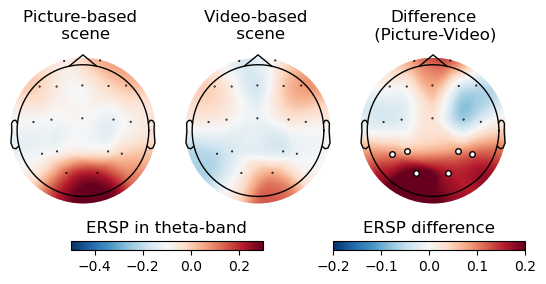

In [12]:
import matplotlib.gridspec as gridspec
result_text_theta=TEXT_THETA[ch].mean()
result_video_theta=VIDEO_THETA[ch].mean()

diff=TEXT_THETA[ch]-VIDEO_THETA[ch]
dif_theta=diff.mean()

fig1,(ax1,ax2,ax3) = plt.subplots(ncols=3)

im,cm   = mne.viz.plot_topomap(result_text_theta, info, axes=ax1, contours=0, show=False,vlim=(-0.5,0.3))   
im,cm   = mne.viz.plot_topomap(result_video_theta, info, axes=ax2,show=False, contours=0, vlim=(-0.5,0.3))  
im2,cm   = mne.viz.plot_topomap(dif_theta, info, axes=ax3, contours=0, show=False,vlim=(-0.2,0.2),mask=mask_theta) 

#two_groups_paired_baseline.mean_diff.plot(ax=ax4);

# manually fiddle the position of colorbar
ax_x_start = 0.22
ax_x_width = 0.3
ax_y_start = 0.27
ax_y_height = 0.02
ax_x_start1 = 0.63
ax_x_width1 = 0.3
ax_y_start1 = 0.27
ax_y_height1 = 0.02

cbar_ax = fig1.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
cbar_ax2 = fig1.add_axes([ax_x_start1, ax_y_start1, ax_x_width1, ax_y_height1])

ax1.set_title('Picture-based \n scene')
ax2.set_title('Video-based \n scene')
ax3.set_title('Difference\n (Picture-Video)')

clb = fig1.colorbar(im, cax=cbar_ax,orientation='horizontal')
clb.ax.set_title('ERSP in theta-band',fontsize=12)
#clb.set_ticks([-0.5,-0.3,-0.1,0,0.1, 0.1])

clb2 = fig1.colorbar(im2, cax=cbar_ax2,orientation='horizontal')
clb2.ax.set_title('ERSP difference',fontsize=12)

#plt.savefig('/Users/maksimenko/Dropbox/!Hein/!FIGURES/ERSP-theta-1.eps',format='eps')

# Comparing ERSP Data in Alpha-band

### Permutation statistics and differences

In [13]:
da=TEXT_ALPHA[ch].to_numpy()
db=VIDEO_ALPHA[ch].to_numpy()
X=[da,db]
F_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(X,n_permutations=10000,tail=0,adjacency=am);
print(clusters)
print(cluster_p_values)

mask_alpha = np.empty([len(ch)])
mask_alpha.fill(False)
for i in clusters:
    mask_alpha[i] = True 

Using a threshold of 3.963472
stat_fun(H1): min=0.014896 max=4.858464
Running initial clustering …
Found 1 cluster


/var/folders/qc/srdfyg99647d_vkjg4_13mp80000gn/T/ipykernel_29637/1745072892.py:4: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(X,n_permutations=10000,tail=0,adjacency=am);


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

[(array([ 6,  7, 12, 13]),)]
[0.0613]


### Visualization (box-plot)

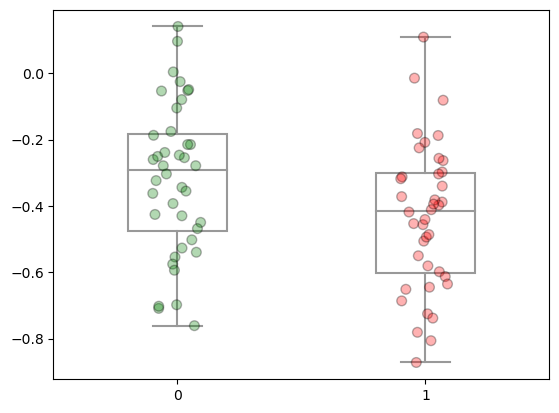

In [14]:
VIDEO_ALPHA['Video']=(VIDEO_ALPHA['O1']+VIDEO_ALPHA['O2']+VIDEO_ALPHA['P4']+VIDEO_ALPHA['Cz'])/4
TEXT_ALPHA['Picture']=(TEXT_ALPHA['O1']+TEXT_ALPHA['O2']+TEXT_ALPHA['P4']+TEXT_ALPHA['Cz'])/4
result_ALPHA=()
result_ALPHA=pd.concat([VIDEO_ALPHA, TEXT_ALPHA], axis = 1)
result_ALPHA = result_ALPHA.loc[:,~result_ALPHA.columns.duplicated()].copy()
result_ALPHA=result_ALPHA[['participant','Video','Picture']]

g1=sns.boxplot([TEXT_ALPHA['Picture'],VIDEO_ALPHA['Video']],width=0.4, color='white')
g1=sns.stripplot([TEXT_ALPHA['Picture'],VIDEO_ALPHA['Video']],linewidth=1, edgecolor='black', alpha=0.3,palette=["green", "red"],size=7)

### Visualization (topoplot)

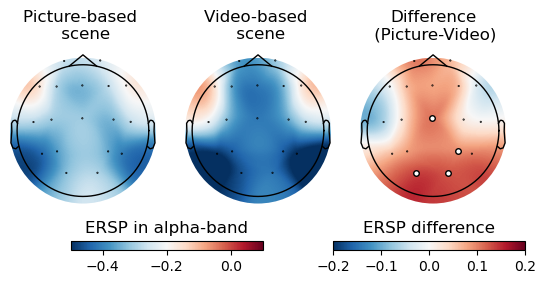

In [15]:
result_text_alpha=TEXT_ALPHA[ch].mean()
result_video_alpha=VIDEO_ALPHA[ch].mean()

diff=TEXT_ALPHA[ch]-VIDEO_ALPHA[ch]
dif_alpha=diff.mean()

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
im,cm   = mne.viz.plot_topomap(result_text_alpha, info, axes=ax1, contours=0, show=False,vlim=(-0.5,0.1))   
im,cm   = mne.viz.plot_topomap(result_video_alpha, info, axes=ax2,show=False, contours=0, vlim=(-0.5,0.1))  
im2,cm   = mne.viz.plot_topomap(dif_alpha, info, axes=ax3, contours=0, show=False,vlim=(-0.2,0.2),mask=mask_alpha) 

# manually fiddle the position of colorbar
ax_x_start = 0.22
ax_x_width = 0.3
ax_y_start = 0.27
ax_y_height = 0.02
ax_x_start1 = 0.63
ax_x_width1 = 0.3
ax_y_start1 = 0.27
ax_y_height1 = 0.02

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
cbar_ax2 = fig.add_axes([ax_x_start1, ax_y_start1, ax_x_width1, ax_y_height1])

ax1.set_title('Picture-based \n scene')
ax2.set_title('Video-based \n scene')
ax3.set_title('Difference\n (Picture-Video)')

clb = fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
clb.ax.set_title('ERSP in alpha-band',fontsize=12)
#clb.set_ticks([-0.5,-0.3,-0.1,0,0.1, 0.1])

clb2 = fig.colorbar(im2, cax=cbar_ax2,orientation='horizontal')
clb2.ax.set_title('ERSP difference',fontsize=12)

plt.savefig('/Users/maksimenko/Dropbox/!Hein/!FIGURES/ERSP-alpha-1.eps',format='eps')

# Comparing ERSP Data in Beta-band

### Permutation statistics and differences

In [16]:
da=TEXT_BETA[ch].to_numpy()
db=VIDEO_BETA[ch].to_numpy()
X=[db,da]
F_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(X,n_permutations=10000,adjacency=am);
print(clusters)
print(cluster_p_values)

mask_beta = np.empty([len(ch)])
mask_beta.fill(False)
for i in clusters:
    mask_beta[i] = True 

Using a threshold of 3.963472
stat_fun(H1): min=0.032784 max=9.710140
Running initial clustering …
Found 1 cluster


/var/folders/qc/srdfyg99647d_vkjg4_13mp80000gn/T/ipykernel_29637/2743651028.py:4: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(X,n_permutations=10000,adjacency=am);


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

[(array([ 0,  6,  7, 12, 13, 16]),)]
[0.0265]


### Visualization (box-plot)

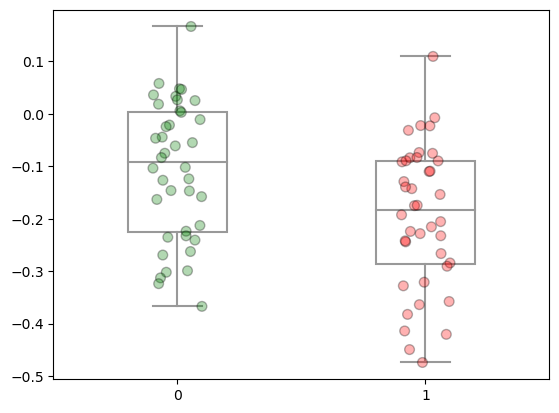

In [18]:
VIDEO_BETA['Video']=(VIDEO_BETA['O1']+VIDEO_BETA['O2']+VIDEO_BETA['P3']+VIDEO_BETA['P4']+VIDEO_BETA['Cz']+VIDEO_BETA['T6'])/6
TEXT_BETA['Picture']=(TEXT_BETA['O1']+TEXT_BETA['O2']+TEXT_BETA['P3']+TEXT_BETA['P4']+TEXT_BETA['Cz']+TEXT_BETA['T6'])/6
result_BETA=()
result_BETA=pd.concat([VIDEO_BETA, TEXT_BETA], axis = 1)
result_BETA = result_BETA.loc[:,~result_BETA.columns.duplicated()].copy()
result_BETA=result_BETA[['participant','Video','Picture']]

g1=sns.boxplot([TEXT_BETA['Picture'],VIDEO_BETA['Video']],width=0.4, color='white')
g1=sns.stripplot([TEXT_BETA['Picture'],VIDEO_BETA['Video']],linewidth=1, edgecolor='black', alpha=0.3,palette=["green", "red"],size=7)

### Visualization (topoplot)

Text(0.5, 1.0, 'ERSP difference')

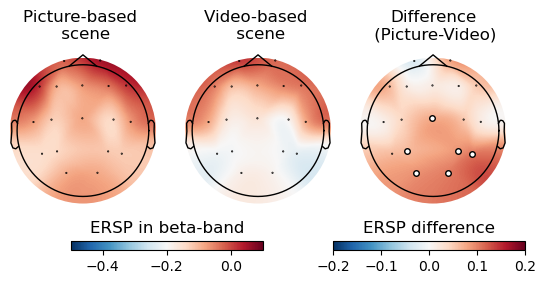

In [19]:
result_text_beta=TEXT_BETA[ch].mean()
result_video_beta=VIDEO_BETA[ch].mean()

diff=TEXT_BETA[ch]-VIDEO_BETA[ch]
dif_beta=diff.mean()

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
im,cm   = mne.viz.plot_topomap(result_text_beta, info, axes=ax1, contours=0, show=False,vlim=(-0.5,0.1))   
im,cm   = mne.viz.plot_topomap(result_video_beta, info, axes=ax2,show=False, contours=0, vlim=(-0.5,0.1))  
im2,cm   = mne.viz.plot_topomap(dif_beta, info, axes=ax3, contours=0, show=False,vlim=(-0.2,0.2),mask=mask_beta) 

# manually fiddle the position of colorbar
ax_x_start = 0.22
ax_x_width = 0.3
ax_y_start = 0.27
ax_y_height = 0.02
ax_x_start1 = 0.63
ax_x_width1 = 0.3
ax_y_start1 = 0.27
ax_y_height1 = 0.02

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
cbar_ax2 = fig.add_axes([ax_x_start1, ax_y_start1, ax_x_width1, ax_y_height1])

ax1.set_title('Picture-based \n scene')
ax2.set_title('Video-based \n scene')
ax3.set_title('Difference\n (Picture-Video)')

clb = fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
clb.ax.set_title('ERSP in beta-band',fontsize=12)
#clb.set_ticks([-0.5,-0.3,-0.1,0,0.1, 0.1])

clb2 = fig.colorbar(im2, cax=cbar_ax2,orientation='horizontal')
clb2.ax.set_title('ERSP difference',fontsize=12)